# Project Goal
Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# Data Preprocessing & Exploration
## Initialization

In [14]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [15]:
pip install scikit-learn --upgrade

In [16]:
pip install category_encoders

In [17]:
pip install lightgbm 

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import sklearn.metrics
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import math
import timeit

### Load Data

In [20]:
auto_df = pd.read_csv('car_data.csv')

In [21]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

## Data Preprocessing

There are 354369 rows and 15 columns. The names of the columns are in uppercase format and many of the features are in datatypes that need to be converted. There are also missing values.

Features
 - DateCrawled — date profile was downloaded from the database
 - VehicleType — vehicle body type
 - RegistrationYear — year of original vehicle registration
 - Gearbox — gearbox type
 - Power — power (hp)
 - Model — vehicle model
 - Mileage — mileage (measured in km due to dataset's regional specifics)
 - RegistrationMonth — month of original vehicle registration
 - FuelType — fuel type
 - Brand — vehicle brand
 - NotRepaired — vehicle repaired or not
 - DateCreated — date of profile creation
 - NumberOfPictures — number of vehicle pictures
 - PostalCode — postal code of profile owner (user)
 - LastSeen — date of the last activity of the user
 
Target
 - Price — price (Euro)


In [22]:
# Converting all features into lowercase names with underscores between terms
auto_df = auto_df.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type',\
                        'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model',\
                        'Mileage': 'mileage', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type',\
                        'Brand': 'brand', 'NotRepaired': 'not_repaired', 'DateCreated': 'date_created',\
                        'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})


In [23]:
auto_df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


We need to select the most import features we need to predict the price to improve the speed and accuracy of our model. It looks like the three column containing date information should not impact the price so we will drop these columns for model training. Likewise, the price of the vehicle should not be affected by the postal code of the owner or the registration month, so we will also drop these columns as well. 

In [24]:
# Dropping the columns

auto_df = auto_df.drop(columns=['date_crawled', 'date_created', 'last_seen', 'postal_code', 'registration_month'], axis=1)

In [25]:
# Checking for duplicate rows

auto_df.duplicated().value_counts()

False    309329
True      45040
dtype: int64

In [26]:
# Dropping duplicated rows

auto_df = auto_df.drop_duplicates()

In [27]:
# Checking for missing values

auto_df.isnull().sum()

price                     0
vehicle_type          34559
registration_year         0
gearbox               17207
power                     0
model                 18361
mileage                   0
fuel_type             30764
brand                     0
not_repaired          64558
number_of_pictures        0
dtype: int64

There are missing values in vehicle_type (37484), gearbox (19830), model (19701), fuel_type(32889), and not_repaired (71145). The data may be missing because it was left out by the user or it could be the result of a technical error. Since there does not seem to be a meaningful way to fill these missing values (other than replacing with "unknown"), and these features are important for predicting our target, we will drop all rows with missing values. Let's see if the remaining data will be sufficient to develop the models.

In [28]:
# Dropping rows with missing values

auto_df = auto_df.dropna()
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209576 entries, 3 to 354367
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               209576 non-null  int64 
 1   vehicle_type        209576 non-null  object
 2   registration_year   209576 non-null  int64 
 3   gearbox             209576 non-null  object
 4   power               209576 non-null  int64 
 5   model               209576 non-null  object
 6   mileage             209576 non-null  int64 
 7   fuel_type           209576 non-null  object
 8   brand               209576 non-null  object
 9   not_repaired        209576 non-null  object
 10  number_of_pictures  209576 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 19.2+ MB


After dropping duplicates and missing values, 245567 rows (69%) of data remain. This is sufficient for model development.

## Exploratory Data Analysis

We will check the data statistics to identify any issues.

In [29]:
# Checking the data's descriptive statistics. 

auto_df.describe()

,price,registration_year,power,mileage,number_of_pictures
count,209576.000000,209576.000000,209576.000000,209576.000000,209576.0
mean,5261.494527,2002.991278,121.071091,126003.192159,0.0
std,4779.064833,6.305215,149.265029,37817.461136,0.0
min,0.000000,1910.000000,0.000000,5000.000000,0.0
25%,1500.000000,1999.000000,76.000000,100000.000000,0.0
50%,3600.000000,2004.000000,114.000000,150000.000000,0.0
75%,7750.000000,2007.000000,150.000000,150000.000000,0.0
max,20000.000000,2018.000000,20000.000000,150000.000000,0.0


There are seven columns with numerical data. The range of price was from 0 to 20000 and the median was 3500. The range of power was from 0 to 20000 and the median was 110. The range for mileage was from 5000 to 150000 and the median was 150000. We will explore the presence of outliers in price, power, and mileage further. Outliers do not pertain to registration_year, registration_month, and postal_code. The feature 'number_of_pictures' contains only zero values so we will drop this feature as well. We need to explore registration_year and registration_month. The minimum registration yaer is 1910 which is an outlier compared to the median which is 2003.

In [30]:
# Dropping 'number_of_pictures' column

auto_df = auto_df.drop(columns=['number_of_pictures'])

In [31]:
# Creating a function to plot the distribution of numerical features with continuous variables: price, power and mileage

def boxplot(column):
    boxplot = auto_df.boxplot(column)
    
    # x-axis label
    xlabel = (column)

    # Adding title
    plt.title("Distribution")

    # show plot
    plt.show()

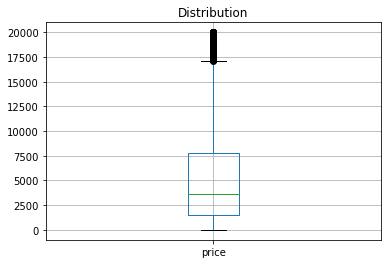

In [32]:
boxplot(['price'])

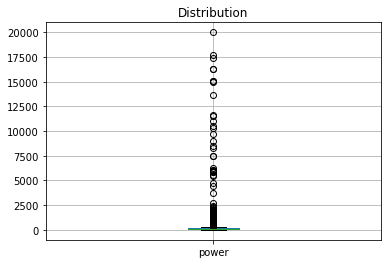

In [33]:
boxplot(['power'])

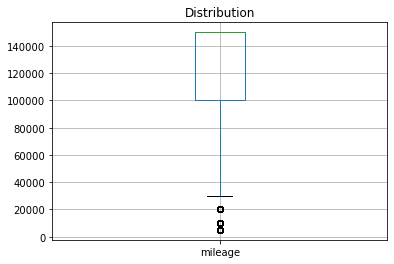

In [34]:
boxplot(['mileage'])

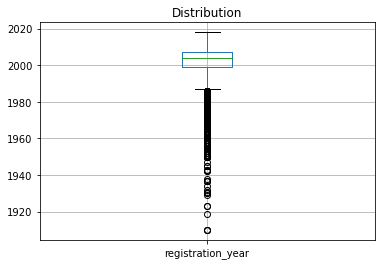

In [35]:
boxplot(['registration_year'])

We will eliminate the outliers in price, power and mileage to aid model development. The registration year may significantly impact the price and we would like to keep a range of vehicles to aid in predicting the price of older vehicles. But since there are fewer instances of the cars below 1990, we may end up with a year in the valid or test set that did not get trained by the model. Therefore, we will also eliminate outliers in registration year.

In [36]:
# Creating function for eliminating outliers

def outliers(df, column):
        
        #finding Q1 and Q2
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
       
        #finding the IQR
        IQR = Q3-Q1
        
        #finding the upper and lower limit
        upper_limit = Q3 + 1.5*IQR
        lower_limit = Q1 - 1.5*IQR
        
        #finding outliers
        df[column > upper_limit]
        df[column < lower_limit]
        
        #trimming
        df = df[column < upper_limit] 
        df = df[column > lower_limit]
    
        return df        

In [37]:
# Eliminating outliers

auto_df= outliers(auto_df, auto_df['price']) 
auto_df= outliers(auto_df, auto_df['power'])
auto_df= outliers(auto_df, auto_df['mileage'])
auto_df= outliers(auto_df, auto_df['registration_year']) 
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164891 entries, 3 to 354367
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              164891 non-null  int64 
 1   vehicle_type       164891 non-null  object
 2   registration_year  164891 non-null  int64 
 3   gearbox            164891 non-null  object
 4   power              164891 non-null  int64 
 5   model              164891 non-null  object
 6   mileage            164891 non-null  int64 
 7   fuel_type          164891 non-null  object
 8   brand              164891 non-null  object
 9   not_repaired       164891 non-null  object
dtypes: int64(4), object(6)
memory usage: 13.8+ MB


In [38]:
# Checking the distributions after eliminating outliers

auto_df.describe()

,price,registration_year,power,mileage
count,164891.000000,164891.000000,164891.000000,164891.000000
mean,4156.387911,2002.380003,116.071860,141026.223384
std,3780.509306,4.799548,51.530739,17571.125505
min,0.000000,1989.000000,0.000000,90000.000000
25%,1300.000000,1999.000000,80.000000,150000.000000
50%,2900.000000,2003.000000,115.000000,150000.000000
75%,5950.000000,2006.000000,150.000000,150000.000000
max,17111.000000,2016.000000,262.000000,150000.000000


After eliminating outliers, the data distribution is more normal and 164891 rows (47%) of our original data remained. We will now prepare the data for model training.

We need to prepare the categorical features for training. First we will select the categorical features. 

In [39]:
# Preparing categorical features for encoding

categorical_features = ['vehicle_type', 'gearbox', 'model','fuel_type', 'brand', 'not_repaired']

We will use one-hot encoding since in this categorical data no relationship exists between categories. We need to check how many unique values the categorical features have so that we know how encoding may affect model training. If there are many unique categories, OHE will create many new columns which will slow down the machine learning. Let's explore the unique values of the categorical features.

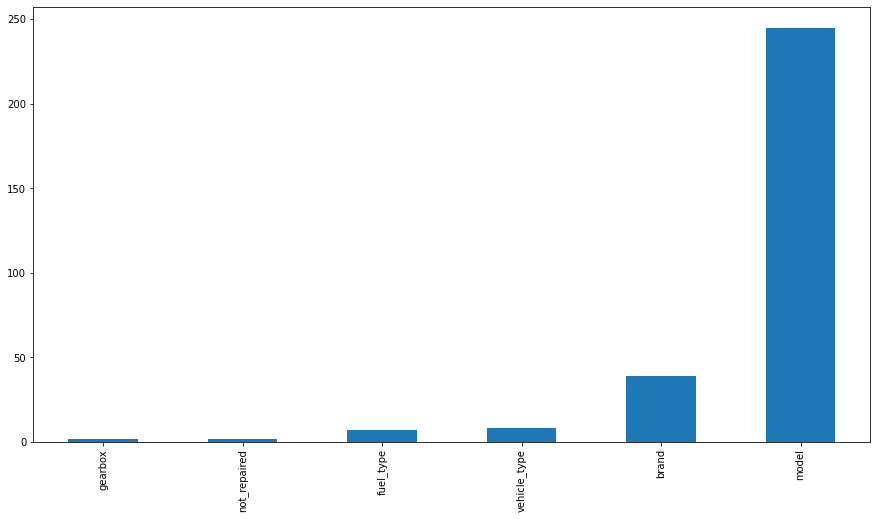

In [40]:
# Plotting the number of unique values in column in the dataframe

plt.figure(figsize=(15, 8))
auto_df[categorical_features].nunique().sort_values().plot(kind='bar')
plt.show()

In [41]:
for feature in categorical_features:
    print(feature, ':', auto_df[feature].value_counts().count())
    print("....................")

vehicle_type : 8
....................
gearbox : 2
....................
model : 245
....................
fuel_type : 7
....................
brand : 39
....................
not_repaired : 2
....................


In [42]:
for feature in categorical_features:
    print(feature, ':', auto_df[feature].value_counts())
    print("....................")

vehicle_type : sedan          48405
wagon          38530
small          35201
bus            17686
convertible    10047
coupe           7899
suv             5796
other           1327
Name: vehicle_type, dtype: int64
....................
gearbox : manual    131657
auto       33234
Name: gearbox, dtype: int64
....................
model : golf          12597
other         11817
3er           11025
a4             5707
passat         5459
              ...  
kalina            2
gl                2
rangerover        2
samara            1
b_max             1
Name: model, Length: 245, dtype: int64
....................
fuel_type : petrol      103330
gasoline     58047
lpg           3046
cng            358
hybrid          67
other           31
electric        12
Name: fuel_type, dtype: int64
....................
brand : volkswagen       33470
bmw              18986
opel             17607
mercedes_benz    16595
audi             15094
ford             11722
renault           8131
peugeot          

The features with the highest number of unique values are model (249) and brand (39). We might be able to regroup the values into fewer categories based on popularity but we cannot group the smaller categories into a group such as "other" since there are categories with less instances that are very different in price. This would mislead the model and affect model training. Therefore, we will keep all of the categories. Hopefully these will not slow down the model training too much.

The best practice when encoding variables is to fit the encoding on the training dataset, then apply it to the validation and test sets. We will first split the dataset, then fit the encoding on the training set, and apply it to the validation and test sets.

## Model Training

We will train different models with various hyperparameters. First we prepare the data for model training by assigning the features and target. We will then split the data into a 3 sets for training, validation and testing the final model. We will create a function using the RMSE metric to evaluate the models. We will then create a dummy model for a sanity check. We will then build several models using a linear regression, a random forest with hyperparameter tuning, LightGBM, and CatBoost. We will analyze the quality of the models. Then we will measure the speed of the most accurate models to compare the speed of the most accurate models.

In [43]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164891 entries, 3 to 354367
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              164891 non-null  int64 
 1   vehicle_type       164891 non-null  object
 2   registration_year  164891 non-null  int64 
 3   gearbox            164891 non-null  object
 4   power              164891 non-null  int64 
 5   model              164891 non-null  object
 6   mileage            164891 non-null  int64 
 7   fuel_type          164891 non-null  object
 8   brand              164891 non-null  object
 9   not_repaired       164891 non-null  object
dtypes: int64(4), object(6)
memory usage: 13.8+ MB


In [44]:
# Converting objects to categorical type needed for LightGBM

auto_df['vehicle_type'] = auto_df.vehicle_type.astype('category')
auto_df['gearbox'] = auto_df.gearbox .astype('category')
auto_df['model'] = auto_df.model.astype('category')
auto_df['fuel_type'] = auto_df.fuel_type.astype('category')
auto_df['brand'] = auto_df.brand.astype('category')
auto_df['not_repaired'] = auto_df.not_repaired.astype('category')

In [45]:
# Preparing data for model training

X = auto_df.drop(['price'], axis=1)
y = auto_df['price']

In [46]:
# Splitting the data using indexing twice to create a 3:1:1 split for training, validation, and testing.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12345)

# We will use valid sets for model training and test set for the final model

In [47]:
# Encoding OHE by fitting features on the training data to avoid target leakage

ohe_encoder = ce.OneHotEncoder(cols = ['vehicle_type', 'gearbox', 'model','fuel_type', 'brand', 'not_repaired'])
X_train_ohe = ohe_encoder.fit_transform(X_train)
X_test_ohe = ohe_encoder.transform(X_test)
X_valid_ohe = ohe_encoder.transform(X_valid)


In [48]:
# Creating a function to calculate RMSE

def rmse(y_valid, y_pred):
    rmse = mean_squared_error(y_valid, y_pred)**0.5
    print("The rmse is:", rmse)

### Dummy Regressor Baseline

We will use the mean of all of the prices in the dataset to generate a dummy regressor prediction. We will use this as our baseline for all other RMSE scores.

In [49]:
%%time
# Creating a dummy model as a baseline

# create a dummy regressor
dummy_reg = DummyRegressor(strategy='mean')
# fit it on the training set
dummy_reg.fit(X_train_ohe, y_train)
# make predictions on the test set
y_pred = dummy_reg.predict(X_valid_ohe)

# calculate root mean squared error
rmse(y_valid, y_pred)

The rmse is: 3791.586038794882
CPU times: total: 31.2 ms
Wall time: 82 ms


### Linear Regression

We will use a linear regression as a sanity check for our model.

In [50]:
%%time
# Training a linear regression model for a sanity check

lr_model = LinearRegression()
lr_model_fit = lr_model.fit(X_train_ohe,y_train)
y_pred = lr_model.predict(X_valid_ohe)
rmse(y_valid, y_pred)

The rmse is: 1991.9172288888392
CPU times: total: 11.2 s
Wall time: 21.9 s


### RandomForestRegressor

In [51]:
%%time
# Developing a model with RandomForestRegressor. Using best score of 3800 from dummy regressor
 
best_score = 3800
best_est = 0
for est in range(1, 5):
    RFR_model = RandomForestRegressor(random_state=12345, n_estimators= est) 
    RFR_model.fit(X_train_ohe,y_train)
    y_pred = RFR_model.predict(X_valid_ohe)
    score = mean_squared_error(y_valid, y_pred)**0.5
    if score < best_score:
        best_score = score # save best score on validation set
        best_est = est # save number of estimators corresponding to best score
        
print("RMSE of the best model on the validation set (n_estimators = {}): {}".format(best_est, best_score))

RMSE of the best model on the validation set (n_estimators = 4): 1574.0930858564923
CPU times: total: 31.9 s
Wall time: 35.5 s


### LightGBMRegressor

LightGBMRegressor is a gradient boosting framework that uses tree based learning algorithms. We previously converted all categorical features to category types so that LightGBM can recognize the categorical features.

In [52]:
%%time
# Building a model using LightGBMRegressor
    
lgb_model = lgb.LGBMRegressor(
    categorical_feature= [1,3,5,7,8,9],
    task = 'predict',
    application = 'regression',
    objective = 'root_mean_squared_error',
    boosting_type="gbdt",
    num_iterations = 1000,
    learning_rate = 0.05,
    num_leaves=15,
    tree_learner='feature',
    max_depth =10,
    min_data_in_leaf=7,
    bagging_fraction = 1,
    bagging_freq = 100,
    reg_sqrt='True',
    metric ='rmse',
    feature_fraction = 0.6,
    random_state=12345)


lgb_model = lgb_model.fit(X_train, y_train, categorical_feature=categorical_features) 

y_pred = lgb_model.predict(X_valid)
rmse(y_valid, y_pred)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
The rmse is: 1421.87496516309
CPU times: total: 16.9 s
Wall time: 6.23 s


### Catboost

In [53]:
%%time
# Developing a model with CatBoostRegressor

categorical_features = ['vehicle_type', 'gearbox', 'model','fuel_type', 'brand', 'not_repaired']

CBR_model = CatBoostRegressor(iterations=500, cat_features=categorical_features, metric_period=50)
CBR_model.fit(X_train, y_train, eval_set=(X_valid,y_valid))
y_pred = CBR_model.predict(X_valid)
rmse(y_valid, y_pred)

Learning rate set to 0.15988
0:	learn: 3383.3317803	test: 3391.2440743	best: 3391.2440743 (0)	total: 319ms	remaining: 2m 39s
50:	learn: 1517.6947238	test: 1524.8464008	best: 1524.8464008 (50)	total: 7.35s	remaining: 1m 4s
100:	learn: 1463.7997024	test: 1479.9832760	best: 1479.9832760 (100)	total: 13.1s	remaining: 51.9s
150:	learn: 1437.6004058	test: 1461.7458445	best: 1461.7458445 (150)	total: 19.8s	remaining: 45.8s
200:	learn: 1419.2091277	test: 1448.9239082	best: 1448.9239082 (200)	total: 25.6s	remaining: 38.1s
250:	learn: 1406.2304520	test: 1442.5192962	best: 1442.5192962 (250)	total: 31.9s	remaining: 31.7s
300:	learn: 1396.0579279	test: 1437.2635654	best: 1437.2635654 (300)	total: 38.6s	remaining: 25.5s
350:	learn: 1386.1814312	test: 1433.6973634	best: 1433.6973634 (350)	total: 45.6s	remaining: 19.3s
400:	learn: 1378.2092790	test: 1431.3272524	best: 1431.3272524 (400)	total: 55s	remaining: 13.6s
450:	learn: 1370.3242137	test: 1428.5428153	best: 1428.5428153 (450)	total: 1m 1s	remai

In [54]:
# Checking feature importances of CatBoost

CBR_model.feature_importances_

array([ 7.96245974, 39.81577165,  0.58445176, 21.77003828,  6.11394458,
        4.13060443,  1.96330413, 14.29254262,  3.36688281])

The CatBoostRegressor found that 'vehicle_type' and 'gearbox' are relatively important predictors of price.

# Model analysis

The LightGBMRegressor and CatBoostRegressor models had the best performance overall, but the LightGBMRegressor was the highest combined for speed and score so we will use this model for our test set.

In [55]:
%%time
#Evaluting best model using test set

lgb_model = lgb.LGBMRegressor(
    categorical_feature= [1,3,5,7,8,9],
    task = 'predict',
    application = 'regression',
    objective = 'root_mean_squared_error',
    boosting_type="gbdt",
    num_iterations = 1000,
    learning_rate = 0.05,
    num_leaves=15,
    tree_learner='feature',
    max_depth =10,
    min_data_in_leaf=7,
    bagging_fraction = 1,
    bagging_freq = 100,
    reg_sqrt='True',
    metric ='rmse',
    feature_fraction = 0.6,
    random_state=12345)


lgb_model = lgb_model.fit(X_train, y_train, categorical_feature=categorical_features) 

y_pred = lgb_model.predict(X_test)
rmse(y_test, y_pred)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
The rmse is: 1389.0992289826563
CPU times: total: 18 s
Wall time: 6.86 s


## General Conclusions

We used Rusty Bargain used car sales data to build a model to predict the value of a car based on its features. We aimed to find the model that had the best combined quality and speed

There were 354369 rows and 15 columns in the dataframe. There wee missing values in vehicle_type (37484), gearbox (19830), model (19701), fuel_type (32889), and not_repaired (71145). The data might be missing because it was left out by the user or it could be the result of a technical error. Since there did not seem to be a meaninful way to fill these missing values (other than replacing with "unknown"), and these features were important for predicting our target, we dropped all rows with missing values.

The three column containing date information should not impact the price so we dropped these columns for model training. Likewise, the price of the vehicle should not be affected by the postal code of the owner or the registration month, so we dropped these columns as well.

There were seven columns with numerical data. We eliminated the outliers in price, power, registration_year, and mileage to aid model development. After eliminating outliers, 164891 rows (47%) of our original data remained.

We encoded categorical variables ('vehicle_type', 'gearbox', 'model','fuel_type', 'brand', 'not_repaired') using one-hot encoding. We checked how many unique values the categorical features have so that we know how encoding may affect model training. The features with the highest number of unique values were model (249) and brand (39). We could not group the smaller categories into a group such as "other" since there are categories with less instances that are very different in price. This would mislead the model and affect model training. Therefore, we kept all of the categories. We converted all categorical features to category types for LightGBM. We first split the dataset, then fit OHE encoding on the training set, and applied it to the validation and test sets so we could use OHE for models that need encoding. We used RMSE to evaluate our models and time magic command to evaluate the speed.

#### The model that had the best combined speed and score was LightGBM.

LightGBMRegressor with the test set
 
The rmse is: 1389.0992289826563
CPU times: total: 18 s
Wall time: 6.86 s

The performance and speed for the LightGBM was better than for all other models and improved from the validation to the test set.